In [1]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import os
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import shap
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_score, recall_score, f1_score
from copy import deepcopy
from math import sqrt
from sklearn.utils import resample
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

In [2]:
derivation_cohort = pd.read_csv("Derivation_dataset.csv")
external_validation_cohort = pd.read_csv("External_validation_dataset.csv")

y = derivation_cohort['Outcome_Occlusion_MI']
X = derivation_cohort.drop('Outcome_Occlusion_MI', axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 99)

for el in X_train.columns:
    X_train[el].fillna(X_train[el].mode()[0], inplace=True)
    X_val[el].fillna(X_train[el].mode()[0], inplace=True)

y_train = np.ravel(np.array(y_train.values))
y_val = np.ravel(np.array(y_val.values))

columns = X_train.columns

X_train = np.array(X_train.values)
X_val = np.array(X_val.values)

scaler = preprocessing.StandardScaler().fit(X_train) # Compute mean and std of training set
X_train = scaler.transform(X_train, copy=True)
X_val = scaler.transform(X_val, copy=True)

C:\Users\arthu\AppData\Local\Temp\ipykernel_88096\1077325655.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[el].fillna(X_train[el].mode()[0], inplace=True)
C:\Users\arthu\AppData\Local\Temp\ipykernel_88096\1077325655.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


In [3]:
def plot_ROC_curve(fpr, tpr, roc_auc, title):
    plt.figure(figsize=[5, 5])
    plt.title(title)
    plt.plot(fpr, tpr, color='b',
                 label=r'LDA (AUC = %0.3f)' % (roc_auc),
                 lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='grey', alpha=.5)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate = 1 - Specificity')
    plt.ylabel('True Positive Rate = Sensitivity')
    plt.legend(loc="lower right")
    plt.show()

In [4]:
def results(pred_probas):
    OMI_score = np.round(pred_probas[:, 1]*100, decimals=2)
    y_pred = np.where(OMI_score<5, 'Low risk', 'Intermediate risk')
    y_pred = np.where(OMI_score>=20, 'High risk', y_pred)
    
    results = {
        'Low risk': [np.count_nonzero(y_pred == 'Low risk')],
        'Intermediate risk': [np.count_nonzero(y_pred == 'Intermediate risk')],
        'High risk': [np.count_nonzero(y_pred == 'High risk')]
    }
    return(pd.DataFrame(data=results, index=['Count (N)']))

In [5]:
def bootstrap_metric_ci(y_true, y_pred, metric_fn, n_bootstrap=1000, alpha=0.05):
    """
    Compute 95% confidence interval using bootstrapping for any metric.
    
    Parameters:
    - y_true: Ground truth labels (0 or 1).
    - y_pred: Predicted values (either probabilities or binary predictions).
    - metric_fn: Metric function (roc_auc_score, recall_score, f1_score).
    - n_bootstrap: Number of bootstrap resamples.
    - alpha: Significance level (default 0.05 for 95% CI).

    Returns:
    - Lower and upper bound of the confidence interval.
    """
    scores = []
    
    for _ in range(n_bootstrap):
        # Resample dataset with replacement
        indices = resample(range(len(y_true)), replace=True, n_samples=len(y_true))
        y_true_bootstrap = np.array(y_true)[indices]
        y_pred_bootstrap = np.array(y_pred)[indices]

        # Special case for AUROC: Use roc_curve and auc()
        if metric_fn == "auroc":
            fpr, tpr, _ = roc_curve(y_true_bootstrap, y_pred_bootstrap)
            score = auc(fpr, tpr)
        else:
            score = metric_fn(y_true_bootstrap, y_pred_bootstrap)

        scores.append(score)
    
    # Compute confidence interval
    lower_bound = np.percentile(scores, 100 * (alpha / 2))
    upper_bound = np.percentile(scores, 100 * (1 - alpha / 2))
    
    return lower_bound, upper_bound

Hyperparameter Tuning with 10-Fold Cross-Validation
Searching for optimal hyperparameters across 52 combinations...


  0%|                                                                                                                                                                                                                          | 0/52 [00:00<?, ?it/s]

Parameters: solver=svd, shrinkage=None, tol=0.0001, CV AUROC=0.8274 ± 0.0519

  4%|████████                                                                                                                                                                                                          | 2/52 [00:00<00:08,  5.92it/s]


Parameters: solver=svd, shrinkage=None, tol=0.001, CV AUROC=0.8274 ± 0.0519


  8%|████████████████▏                                                                                                                                                                                                 | 4/52 [00:00<00:08,  5.81it/s]

Parameters: solver=svd, shrinkage=None, tol=0.01, CV AUROC=0.8274 ± 0.0519
Parameters: solver=svd, shrinkage=None, tol=0.1, CV AUROC=0.8281 ± 0.0521


 13%|████████████████████████████▎                                                                                                                                                                                     | 7/52 [00:00<00:04, 10.77it/s]

Parameters: solver=lsqr, shrinkage=None, tol=0.0001, CV AUROC=0.8274 ± 0.0519
Parameters: solver=lsqr, shrinkage=None, tol=0.001, CV AUROC=0.8274 ± 0.0519
Parameters: solver=lsqr, shrinkage=None, tol=0.01, CV AUROC=0.8274 ± 0.0519
Parameters: solver=lsqr, shrinkage=None, tol=0.1, CV AUROC=0.8274 ± 0.0519


 21%|████████████████████████████████████████████▏                                                                                                                                                                    | 11/52 [00:01<00:03, 13.15it/s]

Parameters: solver=lsqr, shrinkage=auto, tol=0.0001, CV AUROC=0.8279 ± 0.0527
Parameters: solver=lsqr, shrinkage=auto, tol=0.001, CV AUROC=0.8279 ± 0.0527
Parameters: solver=lsqr, shrinkage=auto, tol=0.01, CV AUROC=0.8279 ± 0.0527


 25%|████████████████████████████████████████████████████▎                                                                                                                                                            | 13/52 [00:01<00:02, 14.12it/s]

Parameters: solver=lsqr, shrinkage=auto, tol=0.1, CV AUROC=0.8279 ± 0.0527
Parameters: solver=lsqr, shrinkage=0.01, tol=0.0001, CV AUROC=0.8285 ± 0.0521
Parameters: solver=lsqr, shrinkage=0.01, tol=0.001, CV AUROC=0.8285 ± 0.0521
Parameters: solver=lsqr, shrinkage=0.01, tol=0.01, CV AUROC=0.8285 ± 0.0521
Parameters: solver=lsqr, shrinkage=0.01, tol=0.1, CV AUROC=0.8285 ± 0.0521


 37%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 19/52 [00:01<00:01, 17.91it/s]

Parameters: solver=lsqr, shrinkage=0.1, tol=0.0001, CV AUROC=0.8213 ± 0.0563
Parameters: solver=lsqr, shrinkage=0.1, tol=0.001, CV AUROC=0.8213 ± 0.0563
Parameters: solver=lsqr, shrinkage=0.1, tol=0.01, CV AUROC=0.8213 ± 0.0563
Parameters: solver=lsqr, shrinkage=0.1, tol=0.1, CV AUROC=0.8213 ± 0.0563
Parameters: solver=lsqr, shrinkage=0.5, tol=0.0001, CV AUROC=0.7879 ± 0.0662


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 25/52 [00:01<00:01, 20.25it/s]

Parameters: solver=lsqr, shrinkage=0.5, tol=0.001, CV AUROC=0.7879 ± 0.0662
Parameters: solver=lsqr, shrinkage=0.5, tol=0.01, CV AUROC=0.7879 ± 0.0662
Parameters: solver=lsqr, shrinkage=0.5, tol=0.1, CV AUROC=0.7879 ± 0.0662
Parameters: solver=lsqr, shrinkage=1, tol=0.0001, CV AUROC=0.6900 ± 0.0714
Parameters: solver=lsqr, shrinkage=1, tol=0.001, CV AUROC=0.6900 ± 0.0714
Parameters: solver=lsqr, shrinkage=1, tol=0.01, CV AUROC=0.6900 ± 0.0714


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 31/52 [00:02<00:00, 21.03it/s]

Parameters: solver=lsqr, shrinkage=1, tol=0.1, CV AUROC=0.6900 ± 0.0714
Parameters: solver=eigen, shrinkage=None, tol=0.0001, CV AUROC=0.8274 ± 0.0519
Parameters: solver=eigen, shrinkage=None, tol=0.001, CV AUROC=0.8274 ± 0.0519
Parameters: solver=eigen, shrinkage=None, tol=0.01, CV AUROC=0.8274 ± 0.0519
Parameters: solver=eigen, shrinkage=None, tol=0.1, CV AUROC=0.8274 ± 0.0519
Parameters: solver=eigen, shrinkage=auto, tol=0.0001, CV AUROC=0.8279 ± 0.0527


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 34/52 [00:02<00:01, 16.48it/s]

Parameters: solver=eigen, shrinkage=auto, tol=0.001, CV AUROC=0.8279 ± 0.0527
Parameters: solver=eigen, shrinkage=auto, tol=0.01, CV AUROC=0.8279 ± 0.0527
Parameters: solver=eigen, shrinkage=auto, tol=0.1, CV AUROC=0.8279 ± 0.0527


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 40/52 [00:02<00:00, 15.32it/s]

Parameters: solver=eigen, shrinkage=0.01, tol=0.0001, CV AUROC=0.8285 ± 0.0521
Parameters: solver=eigen, shrinkage=0.01, tol=0.001, CV AUROC=0.8285 ± 0.0521
Parameters: solver=eigen, shrinkage=0.01, tol=0.01, CV AUROC=0.8285 ± 0.0521
Parameters: solver=eigen, shrinkage=0.01, tol=0.1, CV AUROC=0.8285 ± 0.0521


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 44/52 [00:02<00:00, 16.15it/s]

Parameters: solver=eigen, shrinkage=0.1, tol=0.0001, CV AUROC=0.8213 ± 0.0563
Parameters: solver=eigen, shrinkage=0.1, tol=0.001, CV AUROC=0.8213 ± 0.0563
Parameters: solver=eigen, shrinkage=0.1, tol=0.01, CV AUROC=0.8213 ± 0.0563
Parameters: solver=eigen, shrinkage=0.1, tol=0.1, CV AUROC=0.8213 ± 0.0563


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 48/52 [00:03<00:00, 16.49it/s]

Parameters: solver=eigen, shrinkage=0.5, tol=0.0001, CV AUROC=0.7879 ± 0.0662
Parameters: solver=eigen, shrinkage=0.5, tol=0.001, CV AUROC=0.7879 ± 0.0662
Parameters: solver=eigen, shrinkage=0.5, tol=0.01, CV AUROC=0.7879 ± 0.0662
Parameters: solver=eigen, shrinkage=0.5, tol=0.1, CV AUROC=0.7879 ± 0.0662


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:03<00:00, 15.19it/s]

Parameters: solver=eigen, shrinkage=1, tol=0.0001, CV AUROC=0.6900 ± 0.0714
Parameters: solver=eigen, shrinkage=1, tol=0.001, CV AUROC=0.6900 ± 0.0714
Parameters: solver=eigen, shrinkage=1, tol=0.01, CV AUROC=0.6900 ± 0.0714
Parameters: solver=eigen, shrinkage=1, tol=0.1, CV AUROC=0.6900 ± 0.0714

Top 5 parameter combinations:
   solver shrinkage     tol  mean_auroc  std_auroc
12   lsqr      0.01  0.0001    0.828482   0.052101
13   lsqr      0.01  0.0010    0.828482   0.052101
14   lsqr      0.01  0.0100    0.828482   0.052101
15   lsqr      0.01  0.1000    0.828482   0.052101
36  eigen      0.01  0.0001    0.828482   0.052101

Best Parameters: {'solver': 'lsqr', 'shrinkage': 0.01, 'tol': 0.0001}
Best Cross-Validation AUROC: 0.8285
Best model saved as 'best_lda_model.pkl'


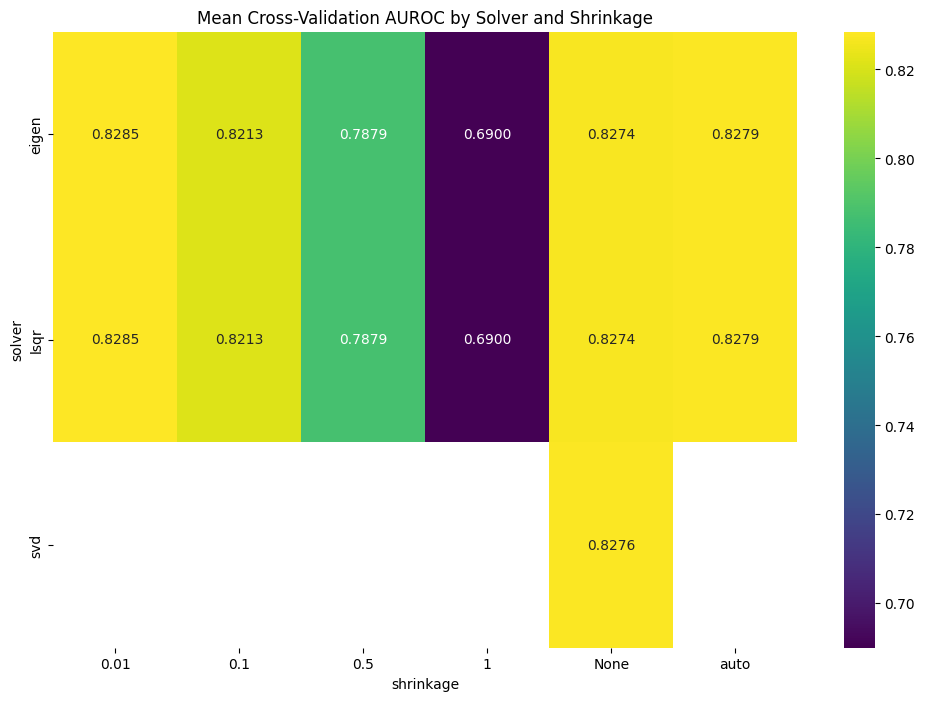

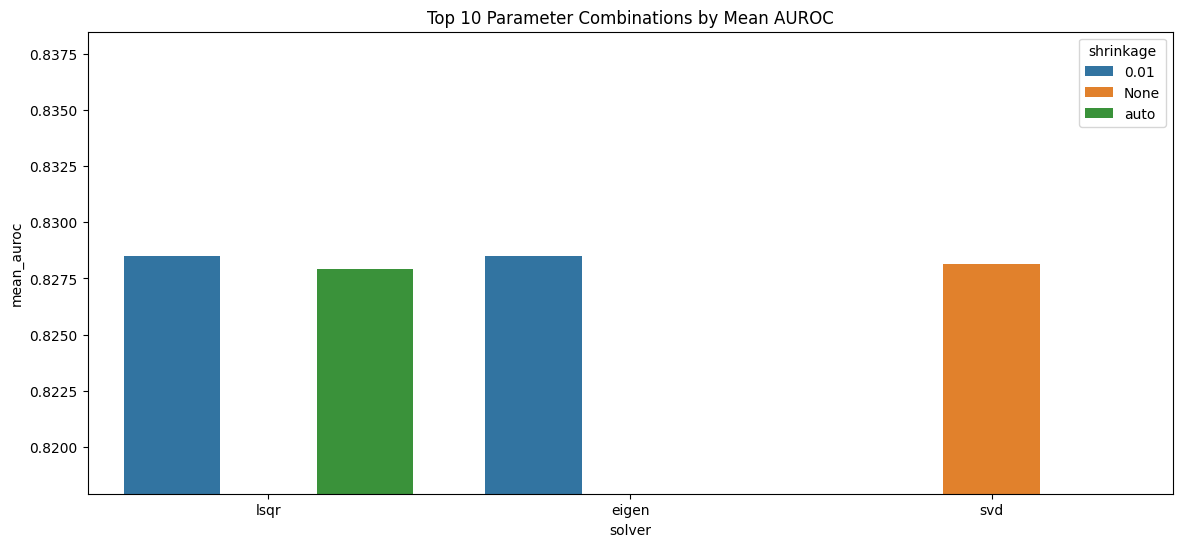

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
from tqdm import tqdm
import pandas as pd

print("Hyperparameter Tuning with 10-Fold Cross-Validation")
best_mean_auroc = 0
best_params = {}
best_model = None

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Parameter grid
solvers = ['svd', 'lsqr', 'eigen']  # LDA solvers
shrinkage_values = [None, 'auto', 0.01, 0.1, 0.5, 1]  # Shrinkage parameters
tol_values = [1e-4, 1e-3, 1e-2, 1e-1]  # Tolerance values

# Calculate total number of valid parameter combinations
total_combinations = 0
for solver in solvers:
    if solver == 'svd':
        total_combinations += len(tol_values)  # svd only works with shrinkage=None
    else:
        total_combinations += len(shrinkage_values) * len(tol_values)

print(f"Searching for optimal hyperparameters across {total_combinations} combinations...")

# Store results for later analysis
results_list = []

# Use tqdm for progress tracking
pbar = tqdm(total=total_combinations)

for solver in solvers:
    # SVD solver doesn't support shrinkage
    shrinkage_options = [None] if solver == 'svd' else shrinkage_values
    
    for shrinkage in shrinkage_options:
        for tol in tol_values:
            try:
                # List to store AUROC scores for each fold
                fold_aurocs = []
                
                # Perform cross-validation
                for train_idx, val_idx in cv.split(X_train, y_train):
                    # Split data for this fold
                    X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
                    y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
                    
                    # Create and train LDA model with current parameters
                    current_lda = LinearDiscriminantAnalysis(solver=solver, shrinkage=shrinkage, tol=tol)
                    current_lda.fit(X_fold_train, y_fold_train)
                    
                    # Evaluate on validation fold using AUROC
                    val_probas = current_lda.predict_proba(X_fold_val)[:, 1]  # Get positive class probabilities
                    auroc_val = roc_auc_score(y_fold_val, val_probas)
                    fold_aurocs.append(auroc_val)
                
                # Calculate mean and standard deviation across folds
                mean_auroc = np.mean(fold_aurocs)
                std_auroc = np.std(fold_aurocs)
                
                print(f"Parameters: solver={solver}, shrinkage={shrinkage}, tol={tol}, CV AUROC={mean_auroc:.4f} ± {std_auroc:.4f}")
                
                # Store results
                results_list.append({
                    'solver': solver,
                    'shrinkage': str(shrinkage),  # Convert to string for better display in DataFrame
                    'tol': tol,
                    'mean_auroc': mean_auroc,
                    'std_auroc': std_auroc
                })
                
                # Track best model based on mean AUROC
                if mean_auroc > best_mean_auroc:
                    best_mean_auroc = mean_auroc
                    best_params = {
                        'solver': solver,
                        'shrinkage': shrinkage,
                        'tol': tol
                    }
            
            except Exception as e:
                print(f"Error with parameters: solver={solver}, shrinkage={shrinkage}, tol={tol}")
                print(f"Error message: {str(e)}")
            
            # Update progress bar
            pbar.update(1)

pbar.close()

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results_list)
print("\nTop 5 parameter combinations:")
print(results_df.sort_values('mean_auroc', ascending=False).head(5))

# Train final model with best parameters on the full training set
best_model = LinearDiscriminantAnalysis(**best_params)
best_model.fit(X_train, y_train)

print(f"\nBest Parameters: {best_params}")
print(f"Best Cross-Validation AUROC: {best_mean_auroc:.4f}")

# If you want to evaluate the best model on a test set (if available)
if 'X_test' in locals() and 'y_test' in locals():
    test_probas = best_model.predict_proba(X_test)[:, 1]
    test_auroc = roc_auc_score(y_test, test_probas)
    print(f"Test set AUROC for best model: {test_auroc:.4f}")

# Save the best model
import joblib
joblib.dump(best_model, 'best_lda_model.pkl')
print("Best model saved as 'best_lda_model.pkl'")

# Use the best model found
clf = best_model

# Optionally, visualize the results
import matplotlib.pyplot as plt
import seaborn as sns

# Plot performance by solver and shrinkage
plt.figure(figsize=(12, 8))
# Create a pivot table of mean AUROC for each solver and shrinkage combination
pivot = results_df.pivot_table(
    index='solver', 
    columns='shrinkage',
    values='mean_auroc',
    aggfunc='mean'  # Mean AUROC across tolerance values
)
sns.heatmap(pivot, annot=True, cmap='viridis', fmt='.4f')
plt.title('Mean Cross-Validation AUROC by Solver and Shrinkage')
plt.savefig('lda_performance_heatmap.png')

# Plot the distribution of AUROC scores for the top performers
plt.figure(figsize=(14, 6))
top_performers = results_df.sort_values('mean_auroc', ascending=False).head(10)
sns.barplot(x='solver', y='mean_auroc', hue='shrinkage', data=top_performers)
plt.title('Top 10 Parameter Combinations by Mean AUROC')
plt.ylim(top_performers['mean_auroc'].min() - 0.01, top_performers['mean_auroc'].max() + 0.01)
plt.savefig('lda_top_performers.png')

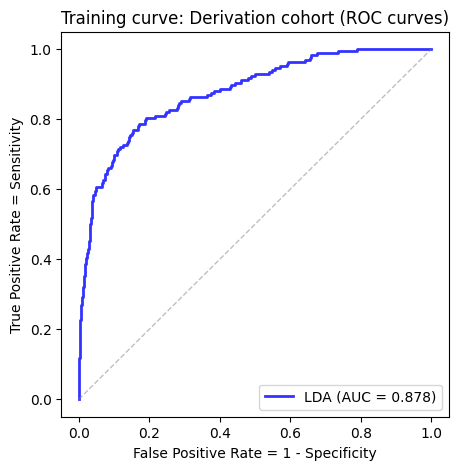

Training AUROC: 0.878 (95% CI: 0.851, 0.905)


In [7]:
# Predict on training data
pred_probas_train = clf.predict_proba(X_train)
risk_groups_train = results(pred_probas_train)

# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_train, pred_probas_train[:,1])
roc_auc = auc(fpr, tpr)
plot_ROC_curve(fpr, tpr, roc_auc, 'Training curve: Derivation cohort (ROC curves)')

# Compute AUROC CI
auroc_ci_lower_train, auroc_ci_upper_train = bootstrap_metric_ci(y_train, pred_probas_train[:,1], "auroc")

print(f"Training AUROC: {roc_auc:.3f} (95% CI: {auroc_ci_lower_train:.3f}, {auroc_ci_upper_train:.3f})")


Val


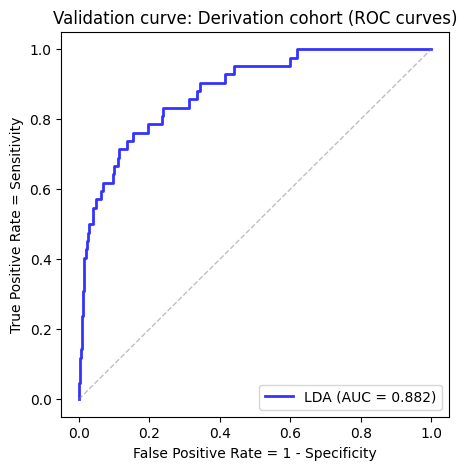

Val AUROC: 0.882 (95% CI: 0.829, 0.929)


In [8]:
# Evaluate on validation set
print("\nVal")
pred_probas_val = clf.predict_proba(X_val)
risk_groups_val = results(pred_probas_val)

# Compute ROC curve and area under the curve for validation set
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, pred_probas_val[:,1])
roc_auc_val = auc(fpr_val, tpr_val)
plot_ROC_curve(fpr_val, tpr_val, roc_auc_val, 'Validation curve: Derivation cohort (ROC curves)')

# Compute AUROC CI
auroc_ci_lower_val, auroc_ci_upper_val = bootstrap_metric_ci(y_val, pred_probas_val[:,1], "auroc")

print(f"Val AUROC: {roc_auc_val:.3f} (95% CI: {auroc_ci_lower_val:.3f}, {auroc_ci_upper_val:.3f})")